# **Prototype Vector Machine for Large Scale Semi-Supervised Learning**

Introduction: We know that collecting labels for our data is neither easy nor budget friendly. That's when semi supervised learning is invented. Here, we don't need labels for entire data. It utilizes small set of labeled data and large set of unlabeled data. It leverages the patterns with in the unlabeled data to improve model performance. SSL works on the assumptions of Smoothness, Manifold and Cluster. That is data points that have higher similarity likely share same label. Graph Based methods are type of SSL. These methods require computation of Kernel matrix which is of size n x n, where n is no. of data points. This requires lot of time,storage and processing power even for a data size of more than 20000. So, is there any alternative for this kernel matrix?

 optimization problem for most of graph based models is:                                              
  \ $min_f tr(f^TSf) + C_1L(f_l,Y_l) + C_2||f_u||^2_F$,where \\

  $f=[f^T_l f^T_u ]^T∈R^{n×c} $ and  \\

  $S=D-K$, $D = diag(K1_n)$

  Here K is a kernel matrix and f is a one hot encoding matrix of labels of data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I used dataset satimage which is multiclass classification problem with 6 labels.

In [ ]:
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/satimage.txt',header=None,nrows=100000,delimiter='\t')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.117596,1.241362,1.184036,0.815302,-0.158561,1.256483,1.193546,0.818486,-0.141965,0.879481,...,0.807707,-0.069968,1.219160,1.250463,0.597678,-0.054291,1.233342,1.262255,0.603258,1
1,-1.205362,-1.249654,-0.077532,0.444886,-0.895959,-0.447579,-0.786760,-0.554203,-0.364672,0.092157,...,-0.192752,-0.736996,-0.969292,-0.844805,-0.400030,-0.725852,-0.344432,-0.594534,-0.183967,5
2,0.779075,0.148811,0.042617,-0.243030,0.800057,0.164136,0.053370,-0.448612,0.154978,-0.345245,...,-0.877277,0.671174,-0.006373,-0.425752,-0.662584,0.691889,0.356801,-0.175259,-0.236449,7
3,1.146564,0.585831,0.342991,0.021553,0.947536,0.601074,0.353416,0.026550,1.788164,1.010702,...,0.281150,1.412317,1.044084,0.532085,0.282612,1.438068,1.058033,0.842981,0.130923,3
4,-0.764376,-1.162250,-0.137607,0.180303,-0.969698,-1.146681,-0.126658,0.184937,-0.735851,-1.132569,...,-0.192752,-0.885225,-1.231906,-0.784941,-0.347519,-0.875088,-1.220973,-0.774223,-0.551339,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6430 entries, 0 to 6429
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6430 non-null   float64
 1   1       6430 non-null   float64
 2   2       6430 non-null   float64
 3   3       6430 non-null   float64
 4   4       6430 non-null   float64
 5   5       6430 non-null   float64
 6   6       6430 non-null   float64
 7   7       6430 non-null   float64
 8   8       6430 non-null   float64
 9   9       6430 non-null   float64
 10  10      6430 non-null   float64
 11  11      6430 non-null   float64
 12  12      6430 non-null   float64
 13  13      6430 non-null   float64
 14  14      6430 non-null   float64
 15  15      6430 non-null   float64
 16  16      6430 non-null   float64
 17  17      6430 non-null   float64
 18  18      6430 non-null   float64
 19  19      6430 non-null   float64
 20  20      6430 non-null   float64
 21  21      6430 non-null   float64
 22  

In [ ]:
df[36].value_counts()

36
1    1531
7    1508
3    1356
5     707
2     703
4     625
Name: count, dtype: int64

This is the distribution of labels in our dataset

If we visualise this data in 2D using PCA, we can observe that clusters having similar labels.

<Figure size 800x600 with 0 Axes>

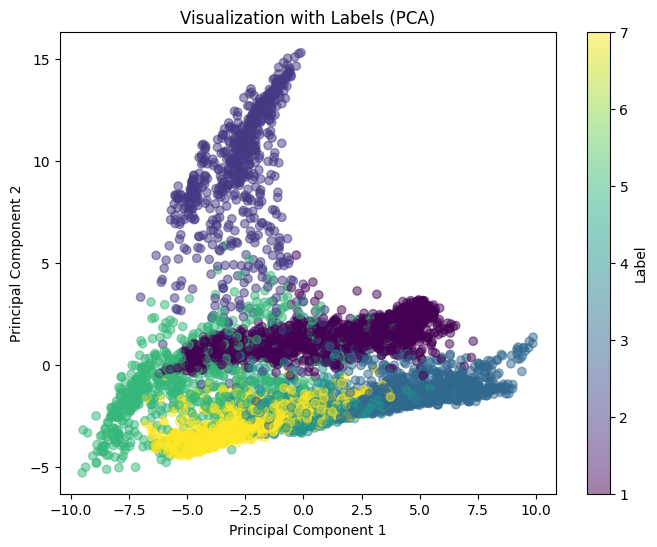

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

x= df.drop([36],axis=1)
y=df.iloc[:,36]
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8, 6))
# Plot with labels
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)  # Use labels for coloring


plt.title('Visualization with Labels (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Label')
plt.show()

I standardised the data because scaling effects the kernel matrix as it includes L2 norm

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

numeric_columns = df.drop(36,axis=1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
scaled_data = scaler.fit_transform(numeric_columns)

# Create a DataFrame from the scaled data
x = pd.DataFrame(scaled_data, columns=numeric_columns.columns)

df=pd.concat([x,df[36]],axis=1)
df


,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.118493,1.242275,1.184772,0.815478,-0.157758,1.257420,1.194288,0.818702,-0.141236,0.880413,...,0.807729,-0.069355,1.219944,1.251065,0.597774,-0.053706,1.234088,1.262811,0.603257,1
1,-1.205033,-1.249073,-0.076938,0.445105,-0.895438,-0.446845,-0.786235,-0.553792,-0.364004,0.092952,...,-0.192537,-0.736503,-0.968629,-0.844331,-0.399741,-0.725401,-0.343788,-0.594106,-0.183802,5
2,0.780255,0.149579,0.043225,-0.242729,0.801226,0.164942,0.053987,-0.448216,0.155787,-0.344526,...,-0.876930,0.671921,-0.005657,-0.425252,-0.662245,0.692624,0.357490,-0.174802,-0.236273,7
3,1.147902,0.586657,0.343633,0.021822,0.948761,0.601933,0.354066,0.026879,1.789416,1.011657,...,0.281273,1.413198,1.044859,0.532643,0.282769,1.438952,1.058768,0.843508,0.131022,3
4,-0.763858,-1.161657,-0.137019,0.180554,-0.969205,-1.146031,-0.126061,0.185243,-0.735283,-1.131987,...,-0.192537,-0.884759,-1.231258,-0.784463,-0.347240,-0.874667,-1.220387,-0.773807,-0.551097,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6425,1.515548,1.111152,1.064610,0.498015,1.243834,0.907827,0.774177,0.343608,1.269625,0.924161,...,0.597146,0.671921,1.395030,0.891854,0.755277,0.692624,1.234088,1.202911,0.603257,3
6426,-0.102095,-0.374915,0.523877,0.709656,0.137314,0.164942,0.534113,0.290819,0.155787,0.355439,...,0.333919,-0.439993,0.169429,0.293169,0.335270,0.095560,0.751959,0.304403,0.131022,4
6427,1.662607,1.242275,0.884365,0.392195,1.317601,0.864128,0.354066,0.026879,0.749834,0.224196,...,-0.192537,0.820177,0.650915,-0.305515,-0.557243,0.543358,0.094510,-0.294603,-0.760978,4
6428,0.118493,-0.200084,-0.857996,-0.824743,-0.452830,-0.359447,-1.086315,-0.817733,-0.141236,-0.169534,...,0.018045,-0.143482,0.038115,-0.365384,-0.557243,0.170193,-0.080809,-0.534205,-0.551097,4


Unlabelled 70% of data such that distribution of labels is maintained

In [ ]:
import pandas as pd
label1 = df[df[36] == 1]
label2 = df[df[36] == 2]
label3 = df[df[36] == 3]
label4 = df[df[36] == 4]
label5 = df[df[36] == 5]
label7 = df[df[36] == 7]
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

Had 200 prototypes using K-means clustering

In [ ]:
x=df.drop(36,axis=1)
kmeans = KMeans(n_clusters=200)
clusters=kmeans.fit_predict(x)
y=df[36]
# Get centroids
centroids = kmeans.cluster_centers_
# Find indices of closest points to centroids
distances = cdist(x, centroids, metric='euclidean')
closest_point_indices = np.argmin(distances, axis=0)
# Get the centroids of each cluster
X1 =x.iloc[closest_point_indices,:]
Y1=y.iloc[closest_point_indices]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
Y1.value_counts()

36
2    49
1    41
5    35
7    31
3    28
4    16
Name: count, dtype: int64

Unlabeled 70% of data

In [ ]:
import pandas as pd
import random
random.seed(41)
def unlabel_data(df, percentage_to_unlabel):
  num_to_unlabel = int(len(df) * percentage_to_unlabel)
  indices_to_unlabel = random.sample(range(len(df)), num_to_unlabel)
  df.loc[indices_to_unlabel, 36] = None # Replace with your label column name
  return df
# Unlabel 70% of the data
label1 = label1.reset_index(drop=True)
label2 = label2.reset_index(drop=True)
label3 = label3.reset_index(drop=True)
label4 = label4.reset_index(drop=True)
label5 = label5.reset_index(drop=True)
label7 = label7.reset_index(drop=True)
D1 = unlabel_data(label1.copy(), 0.7)
D2 = unlabel_data(label2.copy(), 0.7)
D3 = unlabel_data(label3.copy(), 0.7)
D4 = unlabel_data(label4.copy(), 0.7)
D5 = unlabel_data(label5.copy(), 0.7)
D7 = unlabel_data(label7.copy(), 0.7)
df1=pd.concat([D1,D2,D3,D4,D5,D7])
df=pd.concat([label1,label2,label3,label4,label5,label7])

In [ ]:
df1[36].value_counts()

36
1.0    460
7.0    453
3.0    407
5.0    213
2.0    211
4.0    188
Name: count, dtype: int64

Computed Kernel Matrix of prototypes

In [ ]:
import numpy as np
import multiprocessing

def compute_distance(i, data1, data2):
    distances = np.zeros(data2.shape[0], dtype=np.float32)
    for j in range(data2.shape[0]):
        distances[j] = np.exp(-np.linalg.norm(data1.iloc[i] - data2.iloc[j])**2)
    return distances

def distance_matrix_parallel(data1, data2):
    num_samples1 = data1.shape[0]
    num_samples2 = data2.shape[0]
    num_processes = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=num_processes)
    results = [pool.apply_async(compute_distance, args=(i, data1, data2)) for i in range(num_samples1)]
    distance_matrix = np.array([result.get() for result in results])
    return distance_matrix

W = distance_matrix_parallel(X1, X1)
W

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.80259693e-45, 3.46390081e-25],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        2.77738398e-16, 5.94574783e-04, 3.69085977e-11],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.77738398e-16, 0.00000000e+00, ...,
        1.00000000e+00, 1.30130151e-12, 1.93272525e-12],
       [2.80259693e-45, 5.94574783e-04, 0.00000000e+00, ...,
        1.30130151e-12, 1.00000000e+00, 1.13787664e-07],
       [3.46390081e-25, 3.69085977e-11, 0.00000000e+00, ...,
        1.93272525e-12, 1.13787664e-07, 1.00000000e+00]], dtype=float32)

In [ ]:
np.linalg.inv(W)

array([[ 1.1280365e+00,  3.2347249e-16, -5.9123927e-27, ...,
         9.0214365e-19, -4.3472386e-16, -2.3813895e-09],
       [ 3.2347249e-16,  1.1309999e+00, -2.4358524e-26, ...,
        -6.6742384e-10, -4.5877075e-04, -3.6837890e-12],
       [-5.9123927e-27, -2.4358524e-26,  1.0001048e+00, ...,
        -2.8284169e-25, -1.5634793e-25, -4.1008929e-21],
       ...,
       [ 9.0214365e-19, -6.6742384e-10, -2.8284169e-25, ...,
         1.0000000e+00, -4.9946958e-09, -2.9854666e-10],
       [-4.3472386e-16, -4.5877075e-04, -1.5634793e-25, ...,
        -4.9946958e-09,  1.0000328e+00,  9.3577086e-08],
       [-2.3813895e-09, -3.6837890e-12, -4.1008929e-21, ...,
        -2.9854666e-10,  9.3577086e-08,  1.0077683e+00]], dtype=float32)

And then kernel matrix of prototypes with entire dataset and approximated K and computed all other required matrices

In [ ]:
x=df1.drop(36,axis=1)
W1=distance_matrix_parallel(x,X1)
K = np.dot(np.dot(W1, np.linalg.inv(W)), W1.T)
row_sums = np.sum(K, axis=1)
# Create a diagonal matrix D with row_sums as diagonal elements
D = np.diag(row_sums)
S=D-K

In [ ]:
H=W1
# Filter rows with non-null values in the first column
dfl = df1.loc[pd.notnull(df1.iloc[:, 36])]
# Filter rows with null values in the first column
dfu = df1.loc[pd.isnull(df1.iloc[:, 36])]
xl=dfl.drop(36,axis=1)
xu=dfu.drop(36,axis=1)
Hl=distance_matrix_parallel(xl,X1)

In [ ]:
Hu=distance_matrix_parallel(xu,X1)

In [ ]:
W1l=Hl

In [ ]:
def response_matrix(data):
  num_samples=len(data)
  response_matrix = np.zeros((num_samples, 6), dtype=np.float32)
  for i in range(num_samples):
    if data.iloc[i]==1.0:
      response_matrix[i, 0] = 1

    elif data.iloc[i]==2.0:
      response_matrix[i,1]=1
    elif data.iloc[i]==3.0:
      response_matrix[i,2]=1
    elif data.iloc[i]==4.0:
      response_matrix[i,3]=1
    elif data.iloc[i]==5.0:
      response_matrix[i,4]=1
    elif data.iloc[i]==7.0:
      response_matrix[i,5]=1
  return response_matrix
yl=dfl.iloc[:,36]
Yl= response_matrix(yl)

In [ ]:
import numpy as np
c1=[0,0.01,0.1,1,5,10,100,1000]
a=[]
for i in c1:
  M1 = np.dot(np.dot(H.T, S), H)+ i* np.dot(Hl.T, Hl) + 0* np.dot(Hu.T, Hu)
  M2 = np.linalg.inv(M1)
  M3 = np.dot(W1l.T, Yl)
  # Step 2: Compute final result
  fv = np.dot(M2, M3)
  f=np.dot(H,fv)
  y_pred=[]
  max_indices = np.argmax(f, axis=1)
  for i in max_indices:
    if i!=5:
      y_pred.append(i+1)
    else:
      y_pred.append(i+2)
  # Create a confusion matrix
  from sklearn.metrics import confusion_matrix
  conf_matrix = confusion_matrix(df.iloc[:,36],y_pred)
  accuracy=0
  for i in range(6):
    accuracy += conf_matrix[i][i]/6430
  a.append(accuracy)


The confusion matrix is as below

In [ ]:

y_pred=[]
max_indices = np.argmax(f, axis=1)
for i in max_indices:
  if i!=5:
    y_pred.append(i+1)
  else:
    y_pred.append(i+2)
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(df.iloc[:,36],y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1496    0   29    1    5    0]
 [   0  662    7    8   19    7]
 [  10    1 1311   24    3    7]
 [   1    4  143  334   12  131]
 [  60    5    0   15  570   57]
 [   0    0   52  137   38 1281]]


The overall accuracy achieved is 87.9%

In [ ]:
accuracy=0
for i in range(6):
  accuracy += conf_matrix[i][i]/6430
print(accuracy)

0.8793157076205288
